# **Team13 Uber and Lyft Surge Price Prediction**

Team Members: I-An Chien (U25013252), Shuo Ming Kuo (U09774481), YI-Cheng Chung (U24763431), Yu Chin Chen(U11038917)

## Background

> As residents living in the Boston area, we benefit from a convenient public transportation system, including commuter rail, subway lines, and bus routes. However, despite these options, sometimes schedules or routes may not fit our specific needs, prompting us to rely on services like Uber and Lyft for convenience. These ride-sharing apps have become an integral part of transportation in the Boston area, and pricing is an important factor in the decision-making process. When considering whether to choose Uber or Lyft, the first thing that comes to mind is price, as people often open both apps to compare and choose the more economical option.
>
> Several factors contribute to price fluctuations on these platforms. For example, demand and supply dynamics play a crucial role, with peak periods or high demand causing higher price. In addition, external factors such as weather conditions, traffic or distance can also affect the cost of a ride. The availability of different vehicle types and service levels also results in different price points.


## Problem Statement

> In this project, our primary objective is to provide a prediction of Uber and Lyft surge prices under different weather and geolocation factors, such as: temperature, rain, wind, pick up location, and destination, to enhance passengers’ ability to make informed booking decisions.
>
> We aim to solve the problem of fluctuating Uber and Lyft fares under the influence of unpredictable surge pricing, offering passengers a reliable tool to estimate the cost of their trips.
>
> Our analysis is geared towards examining the Uber and Lyft trips in Boston during 11/26/2018 to.12/18/2018. By finding the most related factors that affect fare prices, we will first use Linear Regression, Decision Tree Regression, Elastic Net Regression, and XGBoost Regression models to find the most accurate model for prediction. Then, we will use feature importance to pinpoint the most important factors that influence price for Uber and Lyft separately.

## Problem importance


> **Provide budgeting suggestions for passengers:**
>
> Our predictive model is designed to predict Uber and Lyft fare prices by understanding the factors that influence surge pricing, including interactions between factors. Our predictive model allows travelers to enter specific trip details such as pick up location, destination, and vehicle type. This feature provides price estimates to travelers, allowing them to plan their budget and travel effectively.
>
> **Provide trip planning suggestions for passengers:**
>
> For passengers who are more flexible on their departure time, our model can also provide alternative times with more affordable prices. Furthermore, for passengers who are unsure about their pick up location, they can use our model to discover suitable locations based on their budget.

## Dataset Description

> Accessing Kaggle's data, cab_rides, and weather datasets provides a valuable opportunity to delve into the dynamics of Uber and Lyft taxi prices during the week of November-December 2018. The cab_rides data set consists of 10 columns and 693,070 rows and provides a comprehensive view of the various types of taxis offered by Uber and Lyft, including pricing and location information.
>
> The weather dataset has 8 columns and 6,275 rows and provides information about weather attributes for various locations and books. This includes temperature, precipitation (rain) and cloud cover information. Integrating weather data into the analysis can provide a better understanding of how external factors such as weather conditions affect Uber and Lyft prices.
>
>
> Datasource : Uber & Lyft Cab prices on Kaggle: direct access link [here](https://www.google.com/url?q=https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices/data&sa=D&source=docs&ust=1701313435214835&usg=AOvVaw3Tns6p20ieTbjcZmfUzg2h)
>
> Number of rows: 693,071 rows
>
> Number of columns:
>
> - cab_rides: 10 columns
> - weather: 8 columns
>
> Variable types:	 string, number, date, integer, boolean

Data description for cab_rides

| Column title       | Description                                                  |
| :----------------- | :----------------------------------------------------------- |
| distance        | distance between source and destination |
| cab_type         | Uber or Lyft |
| time_stamp | epoch time when data was queried |
| destination       | destination of the ride |
| source    | the starting point of the ride |
| price       | price estimate for the ride in USD |
| surge_multiplier       | the multiplier by which price was increased, default 1 |
| id     | unique identifier |
| product_id | uber/lyft identifier for cab-type |
| name  | Visible type of the cab eg: Uber Pool, UberXL |




Data description for weather

| Column title       | Description                                                  |
| :----------------- | :----------------------------------------------------------- |
| temp        | Temperature in F |
| location         | Location name |
| clouds | Clouds |
| pressure       | pressure in mb |
| rain    | rain in inches for the last hr|
| time_stamp       | epoch time when row data was collected |
| humidity       | thumidity in % |
| wind     | wind speed in mph |

# Data Processing

## Import library & Document

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')
cab_df = pd.read_csv("/content/drive/MyDrive/BA_810_Group13/cab_rides.csv")
weather = pd.read_csv("/content/drive/MyDrive/BA_810_Group13/weather.csv")

Mounted at /content/drive


## Data Cleaning

### Aligning cab_rides and weather units

Since the cab_df and weather use different time frequencies, we added a new column "merge_date" to take the average weather data by hour, and matched it to the trips table on the hour extracted from the timestamp.

In [ ]:
# Unifing timestamp format and turn to datetime
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather['date_time'] = pd.to_datetime(weather['time_stamp'], unit='s')

In [ ]:
# Create a new column for merging, and imputing rain columns with 0
cab_df['merge_date'] = cab_df['source'].astype(str) + " - " + cab_df['date_time'].dt.date.astype(str) + " - " + cab_df['date_time'].dt.hour.astype(str)
weather['merge_date'] = weather['location'].astype(str) + " - " + weather['date_time'].dt.date.astype(str) + " - " + weather['date_time'].dt.hour.astype(str)

groupby_value = weather.groupby(['merge_date']).mean().reset_index()
groupby_value['rain'].fillna(0,inplace=True)

In [ ]:
# Merge two dataframe and drop NAN
groupby_value.index = groupby_value['merge_date']
merged_df = cab_df.join(groupby_value,on=['merge_date'],rsuffix ='_w')
merged_df.dropna(inplace=True)
merged_df.head(5)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date,merge_date_w,temp,clouds,pressure,rain,time_stamp_w,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000128,Haymarket Square - 2018-12-16 - 9,Haymarket Square - 2018-12-16 - 9,38.460,0.290000,1022.25,0.000,1.544954e+09,0.760000,7.68
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2,Haymarket Square - 2018-11-27 - 2,44.065,0.995000,1002.88,0.106,1.543286e+09,0.895000,12.63
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000192,Haymarket Square - 2018-11-30 - 4,Haymarket Square - 2018-11-30 - 4,35.080,0.000000,1013.71,0.000,1.543554e+09,0.700000,5.25
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000064,Haymarket Square - 2018-11-29 - 3,Haymarket Square - 2018-11-29 - 3,37.680,0.433333,998.42,0.000,1.543461e+09,0.706667,11.16
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,2018-12-17 18:25:12.138000128,Haymarket Square - 2018-12-17 - 18,Haymarket Square - 2018-12-17 - 18,40.780,0.930000,1000.15,0.000,1.545072e+09,0.790000,7.55


# Descriptive Analysis

## Which apps have lower prices, Uber or Lyft?

> Customers usually want to save money, so they usually open both apps to compare prices before making a decision. One of the main factors that affects prices is the distance between origin and destination. Using this data, we can look at the average price for each app based on distance traveled.

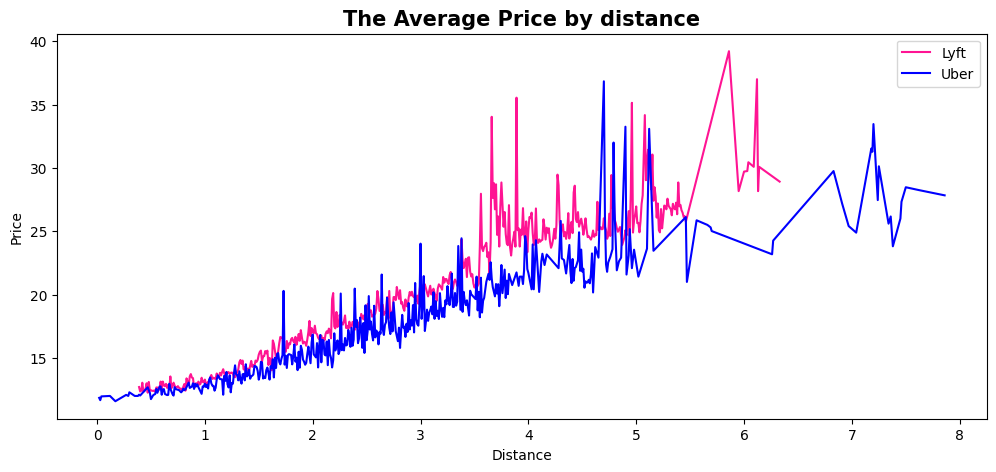

In [ ]:
# plotting distance against price
fig , ax = plt.subplots(figsize = (12,5))
ax.plot(merged_df[merged_df['cab_type'] == 'Lyft'].groupby('distance').price.mean().index,
        merged_df[merged_df['cab_type'] == 'Lyft'].groupby('distance').price.mean(),
        label = 'Lyft', color='deeppink')

ax.plot(merged_df[merged_df['cab_type'] == 'Uber'].groupby('distance').price.mean().index,
        merged_df[merged_df['cab_type'] =='Uber'].groupby('distance').price.mean(),
        label = 'Uber', color='blue')

ax.set_title('The Average Price by distance', fontsize= 15, fontweight='bold')
ax.set(xlabel = 'Distance', ylabel = 'Price' )
ax.legend()
plt.show()

> From above figure, we can observe that for long-distance trips (distances exceeding 5 miles), Lyft tends to have a higher price. Therefore, it is advisable to opt for Uber in such cases.
>
> However, for short-distance trips (distances less than 5 miles), Uber can occasionally have higher costs.

## Do Uber and Lyft have different prices for various vehicle types?

> Sometimes customers are traveling with friends or family and require a larger vehicle, and other times they seek luxury travel. Therefore, it becomes crucial to understand which apps customers should choose based on vehicle type.

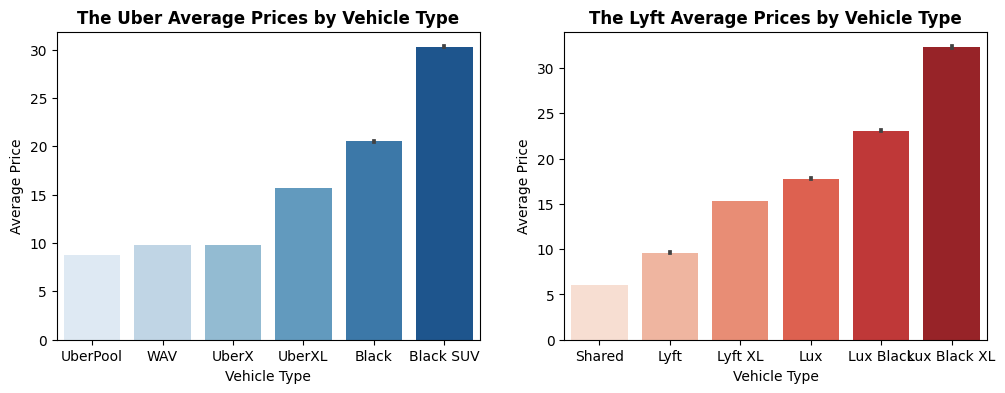

In [ ]:
# plotting Vehicle Type against average price
uber_order =[ 'UberPool','WAV', 'UberX', 'UberXL', 'Black','Black SUV' ]
lyft_order = ['Shared', 'Lyft', 'Lyft XL', 'Lux', 'Lux Black', 'Lux Black XL']
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1 = sns.barplot(x = merged_df[merged_df['cab_type'] == 'Uber'].name,
                  y = merged_df[merged_df['cab_type'] == 'Uber'].price ,
                  ax = ax[0], order = uber_order,palette='Blues')

ax2 = sns.barplot(x = merged_df[merged_df['cab_type'] == 'Lyft'].name,
                  y = merged_df[merged_df['cab_type'] == 'Lyft'].price ,
                  ax = ax[1], order = lyft_order,palette='Reds')

ax1.set(xlabel = 'Vehicle Type', ylabel = 'Average Price')
ax2.set(xlabel = 'Vehicle Type', ylabel = 'Average Price')

ax1.set_title('The Uber Average Prices by Vehicle Type', fontweight='bold')
ax2.set_title('The Lyft Average Prices by Vehicle Type', fontweight='bold')

plt.show()

> From above figures, comparing the price differences for various vehicle types, even when opting for shared rides, Uber (UberPool) tends to be more expensive than Lyft (Shared).
>
> If you're looking for a smaller vehicle type, Lyft (Lyft) is generally more affordable compared to Uber (UberX).
>
> However, when considering larger vehicle types (XL), Uber (UberXL) typically comes with a higher price tag than Lyft (LyftXL).
>
> For a premium service, it's recommended to choose Uber (UberBlack).

## How do prices vary based on different pick-up locations?

> It is possible that the pricing fluctuations are correlated with demand. Therefore, we would like to know whether there is a price difference among various pick-up locations. Understanding such variations can shed light on the impact of demand on pricing in different areas.

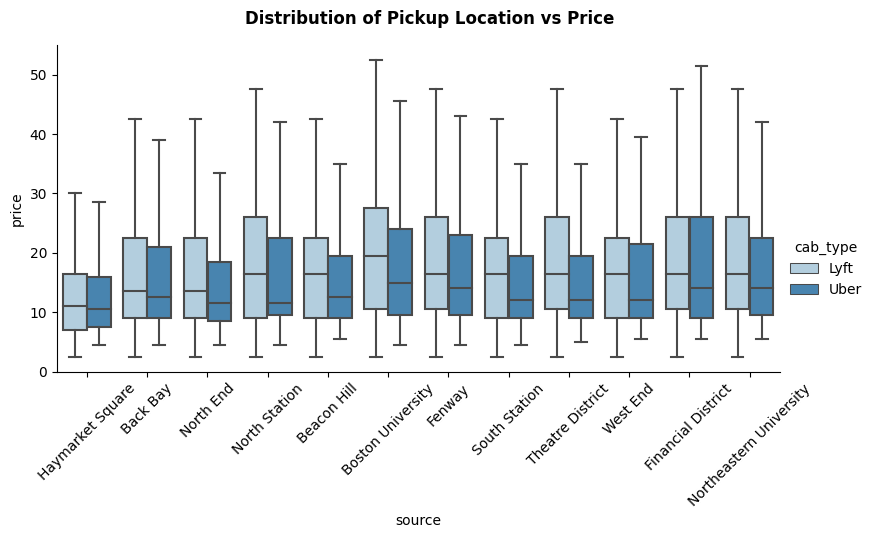

In [ ]:
# plotting source against price
sns.catplot(x='source', y='price', data=merged_df, kind='box', hue='cab_type', sym='', height=4, aspect=2, palette='Blues', dodge=True)
plt.tick_params(axis='x', rotation=45)
plt.suptitle("Distribution of Pickup Location vs Price", y=1.05, fontweight='bold')
plt.show()

> From above figure, we are comparing the price differences from various pick up locations.
>
> We observe that prices tend to be higher when starting from places like Boston University, Fenway, and Northeastern University.
>
> One possible reason for this could be high demand in those areas. Additionally, the prices in the Financial District are more varied, which might be related to the distance of the trips.

# Modeling

Which methods worked best for your problem?


We decided to implement three distinct search methods—GridSearch, RandomizedSearch, and Bayes Search—across four unique models—Linear Regression, Decision Tree Regression,  XGBoost Regression and Elastic Net Regression—to achieve hyperparameter tuning. The goal was to identify the optimal models for both Uber and Lyft. To assess the models' performance, we compared the negative root mean squared error for each and selected the model with the highest value. Subsequently, we utilized the chosen model to make predictions on the test dataset.
Notably, the best models for both datasets turned out to be XGBoost, utilizing the Bayes Search method.

Uber's best parameters in XGBoost:

1. colsample_bytree: 0.826784
2. max_depth: 5
3. n_estimators: 169

Lyft's best parameters in XGBoost:

1. colsample_bytree: 0.87526
2. max_depth: 7
3. n_estimators: 164

In [ ]:
# Selecting features
merged_df = merged_df[['distance','cab_type','destination','source','price','name','date_time','merge_date','temp','clouds','pressure','rain','humidity','wind']]

# Creating time period variable and mapping
merged_df['hour'] = merged_df['date_time'].dt.hour.astype(str)
mapping = {
    '6': 'morning','7' : 'morning','8' : 'morning','9' : 'morning',
    '10' : 'noon', '11' : 'noon','12' : 'noon', '13' : 'noon',
    '14' : 'afternoon', '15' : 'afternoon', '16' : 'afternoon', '17' : 'afternoon',
    '18' : 'evening', '19' : 'evening', '20' : 'evening', '21' : 'evening',
    '22' : 'night', '23' : 'night', '0' : 'night', '1' : 'night',
    '2' : 'night', '3' : 'late_night', '4' : 'late_night', '5' : 'late_night' }
merged_df['time_period'] = merged_df['hour'].replace(mapping)

merged_df.drop(columns=['date_time','merge_date','hour'],axis=1, inplace=True)
merged_df.head(5)

,distance,cab_type,destination,source,price,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,0.44,Lyft,North Station,Haymarket Square,5.0,Shared,38.460,0.290000,1022.25,0.000,0.760000,7.68,morning
1,0.44,Lyft,North Station,Haymarket Square,11.0,Lux,44.065,0.995000,1002.88,0.106,0.895000,12.63,night
3,0.44,Lyft,North Station,Haymarket Square,26.0,Lux Black XL,35.080,0.000000,1013.71,0.000,0.700000,5.25,late_night
4,0.44,Lyft,North Station,Haymarket Square,9.0,Lyft XL,37.680,0.433333,998.42,0.000,0.706667,11.16,late_night
5,0.44,Lyft,North Station,Haymarket Square,16.5,Lux Black,40.780,0.930000,1000.15,0.000,0.790000,7.55,evening


In [ ]:
# Subsetting dataframe into uber and lyft
df_lyft = merged_df[merged_df['cab_type']=='Lyft'].copy()
df_uber = merged_df[merged_df['cab_type']=='Uber'].copy()

# Creating target and features
X_lyft = df_lyft.drop('price',axis=1)
y_lyft = df_lyft['price'].copy()

X_uber = df_uber.drop('price',axis=1)
y_yber = df_uber['price'].copy()

In [ ]:
# Info for Uber Dataframe
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329140 entries, 12 to 693070
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   distance     329140 non-null  float64
 1   cab_type     329140 non-null  object 
 2   destination  329140 non-null  object 
 3   source       329140 non-null  object 
 4   price        329140 non-null  float64
 5   name         329140 non-null  object 
 6   temp         329140 non-null  float64
 7   clouds       329140 non-null  float64
 8   pressure     329140 non-null  float64
 9   rain         329140 non-null  float64
 10  humidity     329140 non-null  float64
 11  wind         329140 non-null  float64
 12  time_period  329140 non-null  object 
dtypes: float64(8), object(5)
memory usage: 35.2+ MB


In [ ]:
# Info for Lyft Dataframe
df_lyft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306102 entries, 0 to 693053
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   distance     306102 non-null  float64
 1   cab_type     306102 non-null  object 
 2   destination  306102 non-null  object 
 3   source       306102 non-null  object 
 4   price        306102 non-null  float64
 5   name         306102 non-null  object 
 6   temp         306102 non-null  float64
 7   clouds       306102 non-null  float64
 8   pressure     306102 non-null  float64
 9   rain         306102 non-null  float64
 10  humidity     306102 non-null  float64
 11  wind         306102 non-null  float64
 12  time_period  306102 non-null  object 
dtypes: float64(8), object(5)
memory usage: 32.7+ MB


In [ ]:
# Splitting data into training and testing for Uber and Lyft dataframes
from sklearn.model_selection import train_test_split
X_train_lyft, X_test_lyft, y_train_lyft, y_test_lyft = train_test_split(X_lyft, y_lyft, test_size=0.2, random_state=42)
X_train_uber, X_test_uber, y_train_uber, y_test_uber = train_test_split(X_uber, y_yber, test_size=0.2, random_state=42)

In [ ]:
# Creating preprocessing pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

set_config(display='diagram')

cat_attribs = ["cab_type", "destination", "source", "name", "time_period"]
num_attribs = ["distance", "temp", "clouds", "pressure", "rain", "humidity", "wind"]

preprocess_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(drop="first"), cat_attribs),
        ("num", StandardScaler(), num_attribs),])

preprocess_pipeline

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['cab_type', 'destination', 'source', 'name',
                                  'time_period']),
                                ('num', StandardScaler(),
                                 ['distance', 'temp', 'clouds', 'pressure',
                                  'rain', 'humidity', 'wind'])])

In [ ]:
# Test if it's preprocessing
print(X_train_lyft.shape)
X_train_lyft_prepared = preprocess_pipeline.fit_transform(X_train_lyft)
print(X_train_lyft_prepared.shape)

(244881, 12)
(244881, 39)


In [ ]:
# Test if it's preprocessing
print(X_train_uber.shape)
X_train_uber_prepared = preprocess_pipeline.fit_transform(X_train_uber)
print(X_train_uber_prepared.shape)

(263312, 12)
(263312, 39)




---



## **Linear Regression**

### Uber

In [ ]:
# Linear regression for Uber dataframe
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg_uber = make_pipeline(preprocess_pipeline, LinearRegression())
lin_reg_uber.fit(X_train_uber, y_train_uber)
y_train_predictions_uber = lin_reg_uber.predict(X_train_uber)
lin_cv_rmses = -cross_val_score(lin_reg_uber, X_train_uber, y_train_uber,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average Linear Regression Cross-Validation RMSE: {lin_cv_rmses.mean():.0f}")

Average Linear Regression Cross-Validation RMSE: 2


In [ ]:
# Linear Regression Grid Search for Uber dataframe
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'linearregression__fit_intercept': [True, False],
    'linearregression__copy_X': [True, False],
    'linearregression__positive': [True, False]
}

lin_uber_grid_search = GridSearchCV(lin_reg_uber, param_grid, cv=3, scoring='neg_root_mean_squared_error')
lin_uber_grid_search.fit(X_train_uber, y_train_uber)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['cab_type',
                                                                          'destination',
                                                                          'source',
                                                                          'name',
                                                                          'time_period']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['distance',
                                                                          'temp',
                                                                          'clouds',
                                                                          'pressure',
                                                                          'rain',
                                                                          'humidity',
                                                                          'wind'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__copy_X': [True, False],
                         'linearregression__fit_intercept': [True, False],
                         'linearregression__positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
lin_uber_cv = pd.DataFrame(lin_uber_grid_search.cv_results_)
lin_uber_cv.sort_values(by="mean_test_score", ascending=False, inplace=True)
lin_uber_cv.filter(regex = '(^param_|mean_test_score)', axis=1)

,param_linearregression__copy_X,param_linearregression__fit_intercept,param_linearregression__positive,mean_test_score
1,True,True,False,-2.402838
5,False,True,False,-2.402838
3,True,False,False,-2.402838
7,False,False,False,-2.402838
0,True,True,True,NaN
2,True,False,True,NaN
4,False,True,True,NaN
6,False,False,True,NaN


In [ ]:
# Linear Regression Random Search for Uber dataframe

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


lin_uber_rnd_search = RandomizedSearchCV(
    lin_reg_uber, param_distributions=param_grid, n_iter=4, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

lin_uber_rnd_search.fit(X_train_uber, y_train_uber)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['cab_type',
                                                                                'destination',
                                                                                'source',
                                                                                'name',
                                                                                'time_period']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['distance',
                                                                                'temp',
                                                                                'clouds',
                                                                                'pressure',
                                                                                'rain',
                                                                                'humidity',
                                                                                'wind'])])),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_iter=4,
                   param_distributions={'linearregression__copy_X': [True,
                                                                     False],
                                        'linearregression__fit_intercept': [True,
                                                                            False],
                                        'linearregression__positive': [True,
                                                                       False]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
lin_uber_rnd_res = pd.DataFrame(lin_uber_rnd_search.cv_results_)
lin_uber_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
lin_uber_rnd_res.filter(regex = '(^param_|mean_test_score)', axis=1)

,param_linearregression__positive,param_linearregression__fit_intercept,param_linearregression__copy_X,mean_test_score
0,False,True,True,-2.402838
1,False,True,False,-2.402838
3,False,False,False,-2.402838
2,True,True,True,NaN




---



In [ ]:
# Linear Regression Bayes Search for Uber dataframe
!pip install scikit-optimize
from sklearn.linear_model import LinearRegression
from skopt import BayesSearchCV
from skopt.space import Categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
sparse_columns = ['cab_type', 'destination', 'source', 'name', 'time_period']

# One-hot encoding categorical features without creating sparse matrices
X_train_uber_selected = X_train_uber[sparse_columns].to_numpy()
uber_bayes_encoder = OneHotEncoder(sparse=False)
X_train_uber_encoded = pd.get_dummies(X_train_uber[sparse_columns])
# Concatenating encoded features with the original dataset
X_train_uber_bayes_final = pd.concat([X_train_uber.drop(columns=sparse_columns), X_train_uber_encoded], axis=1)

param_space = {
    'fit_intercept': Categorical([True, False]),
    'copy_X': Categorical([True, False]),
    'positive': Categorical([True, False])
}

lin_uber_bayesian_search = BayesSearchCV(
    estimator=LinearRegression(),
    search_spaces=param_space,
    n_iter=8,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

lin_uber_bayesian_search.fit(X_train_uber_bayes_final, y_train_uber)

BayesSearchCV(cv=3, estimator=LinearRegression(), n_iter=8, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'copy_X': Categorical(categories=(True, False), prior=None),
                             'fit_intercept': Categorical(categories=(True, False), prior=None),
                             'positive': Categorical(categories=(True, False), prior=None)})

In [ ]:
# Presenting result
lin_uber_bayes_res = pd.DataFrame(lin_uber_bayesian_search.cv_results_)
lin_uber_bayes_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
lin_uber_bayes_res.filter(regex = '(^param_|mean_test_score)', axis=1)

,param_copy_X,param_fit_intercept,param_positive,mean_test_score
3,True,False,True,-2.402829
4,True,False,True,-2.402829
1,True,True,False,-2.402838
2,False,True,False,-2.402838
5,True,True,False,-2.402838
6,True,True,False,-2.402838
7,True,True,False,-2.402838
0,False,True,True,-2.402908


### Lyft

In [ ]:
# Linear regression for Lyft dataframe

lin_reg_lyft = make_pipeline(preprocess_pipeline, LinearRegression())
lin_reg_lyft.fit(X_train_lyft, y_train_lyft)
y_train_predictions_lyft = lin_reg_lyft.predict(X_train_lyft)
lin_cv_rmses = -cross_val_score(lin_reg_lyft, X_train_lyft, y_train_lyft,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average Linear Regression Cross-Validation RMSE: {lin_cv_rmses.mean():.0f}")

Average Linear Regression Cross-Validation RMSE: 3


In [ ]:
# Linear Regression Grid Search for Lyft dataframe

param_grid = {
    'linearregression__fit_intercept': [True, False],
    'linearregression__copy_X': [True, False],
    'linearregression__positive': [True, False]
}

lin_lyft_grid_search = GridSearchCV(lin_reg_lyft, param_grid, cv=3, scoring='neg_root_mean_squared_error')
lin_lyft_grid_search.fit(X_train_lyft, y_train_lyft)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['cab_type',
                                                                          'destination',
                                                                          'source',
                                                                          'name',
                                                                          'time_period']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['distance',
                                                                          'temp',
                                                                          'clouds',
                                                                          'pressure',
                                                                          'rain',
                                                                          'humidity',
                                                                          'wind'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'linearregression__copy_X': [True, False],
                         'linearregression__fit_intercept': [True, False],
                         'linearregression__positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
lin_lyft_cv = pd.DataFrame(lin_lyft_grid_search.cv_results_)
lin_lyft_cv.sort_values(by="mean_test_score", ascending=False, inplace=True)
lin_lyft_cv.filter(regex = '(^param_|mean_test_score)', axis=1)

,param_linearregression__copy_X,param_linearregression__fit_intercept,param_linearregression__positive,mean_test_score
1,True,True,False,-3.47924
5,False,True,False,-3.47924
3,True,False,False,-3.47924
7,False,False,False,-3.47924
0,True,True,True,NaN
2,True,False,True,NaN
4,False,True,True,NaN
6,False,False,True,NaN


In [ ]:
# Linear Regression Random Search for Lyft dataframe

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


lin_lyft_rnd_search = RandomizedSearchCV(
    lin_reg_lyft, param_distributions=param_grid, n_iter=4, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

lin_lyft_rnd_search.fit(X_train_lyft, y_train_lyft)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['cab_type',
                                                                                'destination',
                                                                                'source',
                                                                                'name',
                                                                                'time_period']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['distance',
                                                                                'temp',
                                                                                'clouds',
                                                                                'pressure',
                                                                                'rain',
                                                                                'humidity',
                                                                                'wind'])])),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_iter=4,
                   param_distributions={'linearregression__copy_X': [True,
                                                                     False],
                                        'linearregression__fit_intercept': [True,
                                                                            False],
                                        'linearregression__positive': [True,
                                                                       False]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
lin_lyft_rnd_res = pd.DataFrame(lin_lyft_rnd_search.cv_results_)
lin_lyft_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
lin_lyft_rnd_res.filter(regex = '(^param_|mean_test_score)', axis=1)

,param_linearregression__positive,param_linearregression__fit_intercept,param_linearregression__copy_X,mean_test_score
0,False,True,True,-3.47924
1,False,True,False,-3.47924
3,False,False,False,-3.47924
2,True,True,True,NaN


In [ ]:
# Linear Regression Bayes Search for Lyft dataframe

X_train_lyft_selected = X_train_lyft[sparse_columns].to_numpy()
lyft_bayes_encoder = OneHotEncoder(sparse=False)
X_train_lyft_encoded = pd.get_dummies(X_train_lyft[sparse_columns])
X_train_lyft_bayes_final = pd.concat([X_train_lyft.drop(columns=sparse_columns), X_train_lyft_encoded], axis=1)


param_space = {
    'fit_intercept': Categorical([True, False]),
    'copy_X': Categorical([True, False]),
    'positive': Categorical([True, False])
}

lin_lyft_bayesian_search = BayesSearchCV(
    estimator=LinearRegression(),
    search_spaces=param_space,
    n_iter=8,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

lin_lyft_bayesian_search.fit(X_train_lyft_bayes_final, y_train_lyft)

BayesSearchCV(cv=3, estimator=LinearRegression(), n_iter=8, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'copy_X': Categorical(categories=(True, False), prior=None),
                             'fit_intercept': Categorical(categories=(True, False), prior=None),
                             'positive': Categorical(categories=(True, False), prior=None)})

In [ ]:
# Presenting result
lin_lyft_bayes_res = pd.DataFrame(lin_lyft_bayesian_search.cv_results_)
lin_lyft_bayes_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
lin_lyft_bayes_res.filter(regex = '(^param_|mean_test_score)', axis=1)

,param_copy_X,param_fit_intercept,param_positive,mean_test_score
1,True,True,False,-3.479240
2,False,True,False,-3.479240
5,True,True,False,-3.479240
6,True,True,False,-3.479240
7,True,True,False,-3.479240
0,False,True,True,-3.479268
3,True,False,True,-3.523841
4,True,False,True,-3.523841


## **DecisionTree Regression**

### Uber

In [ ]:
# DecisionTreeRegressor for Uber dataframe
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

tree_uber = make_pipeline(preprocess_pipeline, DecisionTreeRegressor(random_state=42))

tree_uber.fit(X_train_uber, y_train_uber)
tree_cv_rmses = -cross_val_score(tree_uber, X_train_uber, y_train_uber,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average DecisionTree Regression Cross-Validation RMSE: {tree_cv_rmses.mean():.0f}")

Average DecisionTree Regression Cross-Validation RMSE: 3


In [ ]:
# DecisionTreeRegressor Grid Search for Uber dataframe
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'decisiontreeregressor__max_depth' : [10,20],
    'decisiontreeregressor__min_samples_split' : [2,5,10],
    'decisiontreeregressor__min_samples_leaf' : [1,5,10]
}

tree_uber_grid_search = GridSearchCV(tree_uber, param_grid, cv=3, scoring='neg_root_mean_squared_error')
tree_uber_grid_search.fit(X_train_uber, y_train_uber)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['cab_type',
                                                                          'destination',
                                                                          'source',
                                                                          'name',
                                                                          'time_period']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['distance',
                                                                          'temp',
                                                                          'clouds',
                                                                          'pressure',
                                                                          'rain',
                                                                          'humidity',
                                                                          'wind'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [10, 20],
                         'decisiontreeregressor__min_samples_leaf': [1, 5, 10],
                         'decisiontreeregressor__min_samples_split': [2, 5,
                                                                      10]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
tree_uber_cv = pd.DataFrame(tree_uber_grid_search.cv_results_)
tree_uber_cv.sort_values(by="mean_test_score", ascending=False, inplace=True)
tree_uber_cv.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,mean_test_score
6,10,10,2,-1.935140
7,10,10,5,-1.935140
8,10,10,10,-1.935140
3,10,5,2,-1.938275
4,10,5,5,-1.938275
5,10,5,10,-1.938275
2,10,1,10,-1.944237
1,10,1,5,-1.946858
0,10,1,2,-1.958493
15,20,10,2,-2.023783


In [ ]:
# DecisionTreeRegressor Random Search for Uber dataframe
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
    'decisiontreeregressor__max_depth' : randint(10,20),
    'decisiontreeregressor__min_samples_split' : randint(2,20),
    'decisiontreeregressor__min_samples_leaf' : randint(1,20)
}

tree_uber_rnd_search = RandomizedSearchCV(
    tree_uber, param_grid, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

tree_uber_rnd_search.fit(X_train_uber, y_train_uber)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['cab_type',
                                                                                'destination',
                                                                                'source',
                                                                                'name',
                                                                                'time_period']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['distance',
                                                                                'temp',
                                                                                'clouds',
                                                                                'pressure',
                                                                                'rain',
                                                                                'humidity',
                                                                                'wind'])])),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=4...
                   param_distributions={'decisiontreeregressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e06596ff3d0>,
                                        'decisiontreeregressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e065974d990>,
                                        'decisiontreeregressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e065969d720>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
tree_uber_rnd_res = pd.DataFrame(tree_uber_rnd_search.cv_results_)
tree_uber_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
tree_uber_rnd_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,mean_test_score
8,12,12,4,-1.933138
9,14,19,8,-1.937784
5,11,1,13,-1.944010
0,16,15,12,-1.959175
7,19,16,16,-1.980236
4,17,12,7,-1.981772
6,19,12,18,-2.001345
1,17,7,12,-2.011283
2,17,4,9,-2.041862
3,17,3,3,-2.070410


In [ ]:
# Install necessary libraries
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Categorical

In [ ]:
# DecisionTreeRegressor Bayes Search for Uber dataframe
param_grid = {
    'decisiontreeregressor__max_depth' : [10,20],
    'decisiontreeregressor__min_samples_split' : [2,5,10],
    'decisiontreeregressor__min_samples_leaf' : [1,5,10]
}

tree_uber_bayesian_search = BayesSearchCV(
    estimator=tree_uber,
    search_spaces=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

tree_uber_bayesian_search.fit(X_train_uber, y_train_uber)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('cat',
                                                                          OneHotEncoder(drop='first'),
                                                                          ['cab_type',
                                                                           'destination',
                                                                           'source',
                                                                           'name',
                                                                           'time_period']),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          ['distance',
                                                                           'temp',
                                                                           'clouds',
                                                                           'pressure',
                                                                           'rain',
                                                                           'humidity',
                                                                           'wind'])])),
                                        ('decisiontreeregressor',
                                         DecisionTreeRegressor(random_state=42))]),
              n_iter=10, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'decisiontreeregressor__max_depth': [10, 20],
                             'decisiontreeregressor__min_samples_leaf': [1, 5,
                                                                         10],
                             'decisiontreeregressor__min_samples_split': [2, 5,
                                                                          10]})

In [ ]:
# Presenting result
tree_uber_bayes_res = pd.DataFrame(tree_uber_bayesian_search.cv_results_)
tree_uber_bayes_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
tree_uber_bayes_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,mean_test_score
9,10,10,5,-1.935140
2,14,10,2,-1.953656
7,15,10,5,-1.965383
0,14,5,10,-1.971660
6,16,10,5,-1.979480
5,17,10,2,-1.992081
1,18,10,5,-2.003567
4,18,5,5,-2.047339
8,20,5,10,-2.082457
3,18,1,5,-2.171583


### Lyft

In [ ]:
# DecisionTreeRegressor for Lyft dataframe
tree_lyft = make_pipeline(preprocess_pipeline, DecisionTreeRegressor(random_state=42))
tree_lyft.fit(X_train_lyft, y_train_lyft)

tree_cv_rmses = -cross_val_score(tree_lyft, X_train_lyft, y_train_lyft,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average DecisionTree Regression Cross-Validation RMSE: {tree_cv_rmses.mean():.0f}")

Average DecisionTree Regression Cross-Validation RMSE: 4


In [ ]:
# DecisionTreeRegressor Grid Search for Lyft dataframe
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'decisiontreeregressor__max_depth' : [10,20],
    'decisiontreeregressor__min_samples_split' : [2,5,10],
    'decisiontreeregressor__min_samples_leaf' : [1,5,10]
}

tree_lyft_grid_search = GridSearchCV(tree_lyft, param_grid, cv=3, scoring='neg_root_mean_squared_error')
tree_lyft_grid_search.fit(X_train_lyft, y_train_lyft)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['cab_type',
                                                                          'destination',
                                                                          'source',
                                                                          'name',
                                                                          'time_period']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['distance',
                                                                          'temp',
                                                                          'clouds',
                                                                          'pressure',
                                                                          'rain',
                                                                          'humidity',
                                                                          'wind'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [10, 20],
                         'decisiontreeregressor__min_samples_leaf': [1, 5, 10],
                         'decisiontreeregressor__min_samples_split': [2, 5,
                                                                      10]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
tree_lyft_cv = pd.DataFrame(tree_lyft_grid_search.cv_results_)
tree_lyft_cv.sort_values(by="mean_test_score", ascending=False, inplace=True)
tree_lyft_cv.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,mean_test_score
6,10,10,2,-3.109589
7,10,10,5,-3.109589
8,10,10,10,-3.109589
3,10,5,2,-3.121271
4,10,5,5,-3.121271
5,10,5,10,-3.121271
2,10,1,10,-3.143029
1,10,1,5,-3.152581
0,10,1,2,-3.162694
15,20,10,2,-3.275394


In [ ]:
# DecisionTreeRegressor Random Search for Lyft dataframe
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
    'decisiontreeregressor__max_depth' : randint(10,20),
    'decisiontreeregressor__min_samples_split' : randint(2,20),
    'decisiontreeregressor__min_samples_leaf' : randint(1,20)
}

tree_lyft_rnd_search = RandomizedSearchCV(
    tree_lyft, param_grid, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

tree_lyft_rnd_search.fit(X_train_lyft, y_train_lyft)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['cab_type',
                                                                                'destination',
                                                                                'source',
                                                                                'name',
                                                                                'time_period']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['distance',
                                                                                'temp',
                                                                                'clouds',
                                                                                'pressure',
                                                                                'rain',
                                                                                'humidity',
                                                                                'wind'])])),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=4...
                   param_distributions={'decisiontreeregressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e06596fcaf0>,
                                        'decisiontreeregressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e0659768850>,
                                        'decisiontreeregressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e065974f160>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
tree_lyft_rnd_res = pd.DataFrame(tree_lyft_rnd_search.cv_results_)
tree_lyft_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
tree_lyft_rnd_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,mean_test_score
9,14,19,8,-3.123658
8,12,12,4,-3.129115
5,11,1,13,-3.155909
0,16,15,12,-3.175492
7,19,16,16,-3.200898
4,17,12,7,-3.218256
6,19,12,18,-3.241673
1,17,7,12,-3.285188
2,17,4,9,-3.374799
3,17,3,3,-3.442527


In [ ]:
# Install necessary libraries
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Categorical

In [ ]:
# DecisionTreeRegressor Bayes Search for Lyft dataframe
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from scipy.stats import randint

param_grid = {
    'decisiontreeregressor__max_depth' : [10,20],
    'decisiontreeregressor__min_samples_split' : [2,5,10],
    'decisiontreeregressor__min_samples_leaf' : [1,5,10]
}

tree_lyft_bayesian_search = BayesSearchCV(
    estimator=tree_lyft,
    search_spaces=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

tree_lyft_bayesian_search.fit(X_train_lyft, y_train_lyft)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('cat',
                                                                          OneHotEncoder(drop='first'),
                                                                          ['cab_type',
                                                                           'destination',
                                                                           'source',
                                                                           'name',
                                                                           'time_period']),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          ['distance',
                                                                           'temp',
                                                                           'clouds',
                                                                           'pressure',
                                                                           'rain',
                                                                           'humidity',
                                                                           'wind'])])),
                                        ('decisiontreeregressor',
                                         DecisionTreeRegressor(random_state=42))]),
              n_iter=10, random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'decisiontreeregressor__max_depth': [10, 20],
                             'decisiontreeregressor__min_samples_leaf': [1, 5,
                                                                         10],
                             'decisiontreeregressor__min_samples_split': [2, 5,
                                                                          10]})

In [ ]:
# Presenting result
tree_lyft_bayes_res = pd.DataFrame(tree_lyft_bayesian_search.cv_results_)
tree_lyft_bayes_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
tree_lyft_bayes_res.filter(regex = '(^param_|mean_test_score)', axis=1).head(10)

,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_leaf,param_decisiontreeregressor__min_samples_split,mean_test_score
9,10,10,5,-3.109589
2,14,10,2,-3.174279
7,15,10,5,-3.196858
6,16,10,5,-3.217336
5,17,10,2,-3.235908
0,14,5,10,-3.238037
1,18,10,5,-3.250482
4,18,5,5,-3.377004
8,20,5,10,-3.425158
3,18,1,5,-3.675220




---



## **Elastic Net Regression**

### Uber

In [ ]:
# Elastic Net regression for Uber dataframe
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

elastic_net_uber = make_pipeline(preprocess_pipeline, ElasticNet())
elastic_net_uber.fit(X_train_uber, y_train_uber)
elastic_net_cv_rmses = -cross_val_score(elastic_net_uber, X_train_uber, y_train_uber,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average Elastic Net Regression Cross-Validation RMSE: {elastic_net_cv_rmses.mean():.0f}")

Average Elastic Net Regression Cross-Validation RMSE: 7


In [ ]:
# Elastic Net Regression Grid Search for Uber dataframe
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'elasticnet__alpha': [0.1, 0.5, 1.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__positive': [True, False],}

elastic_net_uber = make_pipeline(preprocess_pipeline, ElasticNet())
elastic_net_grid_search = GridSearchCV(elastic_net_uber, param_grid, cv=3, scoring='neg_root_mean_squared_error')
elastic_net_grid_search.fit(X_train_uber, y_train_uber)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['cab_type',
                                                                          'destination',
                                                                          'source',
                                                                          'name',
                                                                          'time_period']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['distance',
                                                                          'temp',
                                                                          'clouds',
                                                                          'pressure',
                                                                          'rain',
                                                                          'humidity',
                                                                          'wind'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.1, 0.5, 1.0],
                         'elasticnet__fit_intercept': [True, False],
                         'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
                         'elasticnet__positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
elastic_net_uber_cv = pd.DataFrame(elastic_net_grid_search.cv_results_)
elastic_net_uber_cv.sort_values(by="mean_test_score", ascending=False, inplace=True)
elastic_net_uber_cv.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_elasticnet__alpha,param_elasticnet__fit_intercept,param_elasticnet__l1_ratio,param_elasticnet__positive,mean_test_score
5,0.1,True,0.9,False,-2.773754
3,0.1,True,0.5,False,-3.413798
1,0.1,True,0.1,False,-3.928199
17,0.5,True,0.9,False,-4.622299
4,0.1,True,0.9,True,-4.695244
2,0.1,True,0.5,True,-5.032953
11,0.1,False,0.9,False,-5.065001
10,0.1,False,0.9,True,-5.282374
0,0.1,True,0.1,True,-5.374240
16,0.5,True,0.9,True,-5.484940


In [ ]:
# Elastic Net Regression Random Search for Uber dataframe
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distribs = {
    'elasticnet__alpha': uniform(0, 1),
    'elasticnet__l1_ratio': uniform(0, 1),
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__positive': [True, False]}

elastic_net_rnd_search = RandomizedSearchCV(
    elastic_net_uber, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

elastic_net_rnd_search.fit(X_train_uber, y_train_uber)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['cab_type',
                                                                                'destination',
                                                                                'source',
                                                                                'name',
                                                                                'time_period']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['distance',
                                                                                'temp',
                                                                                'clouds',
                                                                                'pressure',
                                                                                'rain',
                                                                                'humidity',
                                                                                'wind'])])),
                                             ('elasticnet', ElasticNet())]),
                   param_distributions={'elasticnet__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e06595be920>,
                                        'elasticnet__fit_intercept': [True,
                                                                      False],
                                        'elasticnet__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e065976acb0>,
                                        'elasticnet__positive': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
elastic_net_uber_rnd_res = pd.DataFrame(elastic_net_rnd_search.cv_results_)
elastic_net_uber_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
elastic_net_uber_rnd_res.filter(regex='^(param_|mean_test_score)').head(10)

,param_elasticnet__alpha,param_elasticnet__fit_intercept,param_elasticnet__l1_ratio,param_elasticnet__positive,mean_test_score
2,0.058084,False,0.333709,False,-5.316421
7,0.139494,False,0.973756,True,-5.386674
8,0.45607,True,0.618386,False,-5.438361
0,0.37454,True,0.183435,False,-5.849585
6,0.431945,True,0.524775,True,-6.352243
5,0.183405,False,0.611653,True,-6.481434
1,0.598658,True,0.445833,True,-6.832557
9,0.514234,False,0.466763,True,-10.021694
3,0.708073,False,0.056412,False,-12.272700
4,0.832443,False,0.000779,False,-12.892390


In [ ]:
# Elastic Net Regression Bayes Search for Uber dataframe
sparse_columns = ['cab_type', 'destination', 'source', 'name', 'time_period']

X_train_uber_selected = X_train_uber[sparse_columns].to_numpy()
uber_bayes_encoder = OneHotEncoder(sparse=False)
X_train_uber_encoded = pd.get_dummies(X_train_uber[sparse_columns])
X_train_uber_bayes_final = pd.concat([X_train_uber.drop(columns=sparse_columns), X_train_uber_encoded], axis=1)

param_distribs = {
    'alpha': (0.01, 1.0, 'uniform'),
    'l1_ratio': (0.01, 1.0, 'uniform'),
    'fit_intercept': [True, False],
    'positive': [True, False]}

elastic_net_bayes_search = BayesSearchCV(
    estimator=ElasticNet(),
    search_spaces=param_distribs,
    n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

elastic_net_bayes_search.fit(X_train_uber_bayes_final, y_train_uber)

BayesSearchCV(cv=3, estimator=ElasticNet(), n_iter=10, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'alpha': (0.01, 1.0, 'uniform'),
                             'fit_intercept': [True, False],
                             'l1_ratio': (0.01, 1.0, 'uniform'),
                             'positive': [True, False]})

In [ ]:
# Presenting result
elastic_net_uber_bayes_search = pd.DataFrame(elastic_net_bayes_search.cv_results_)
elastic_net_uber_bayes_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
elastic_net_uber_bayes_search.filter(regex='^(param_|mean_test_score)').head(10)

,param_alpha,param_fit_intercept,param_l1_ratio,param_positive,mean_test_score
9,0.013594,True,0.74387,False,-2.417090
0,0.416003,True,0.933539,False,-3.780388
2,0.450384,True,0.113811,False,-6.048618
8,0.955923,True,0.872935,False,-6.294131
7,0.547969,True,0.501502,True,-6.410722
5,0.736688,True,0.171971,False,-6.702840
6,0.620909,True,0.365433,True,-6.768686
3,0.814272,False,0.602067,True,-6.811925
4,0.801558,False,0.531354,True,-6.893178
1,0.839014,True,0.310376,True,-7.158599


### Lyft

In [ ]:
# Elastic Net regression for Lyft dataframe

elastic_net_lyft = make_pipeline(preprocess_pipeline, ElasticNet())
elastic_net_lyft.fit(X_train_lyft, y_train_lyft)
y_train_predictions_lyft = elastic_net_lyft.predict(X_train_lyft)
elastic_net_cv_rmses = -cross_val_score(elastic_net_lyft, X_train_lyft, y_train_lyft,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average Elastic Net Regression Cross-Validation RMSE: {elastic_net_cv_rmses.mean():.0f}")

Average Elastic Net Regression Cross-Validation RMSE: 8


In [ ]:
# Elastic Net Regression Grid Search for Lyft dataframe

param_grid = {
    'elasticnet__alpha': [0.1, 0.5, 1.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__positive': [True, False],}

elastic_net_lyft = make_pipeline(preprocess_pipeline, ElasticNet())
elastic_net_grid_search = GridSearchCV(elastic_net_lyft, param_grid, cv=3, scoring='neg_root_mean_squared_error')
elastic_net_grid_search.fit(X_train_lyft, y_train_lyft)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['cab_type',
                                                                          'destination',
                                                                          'source',
                                                                          'name',
                                                                          'time_period']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['distance',
                                                                          'temp',
                                                                          'clouds',
                                                                          'pressure',
                                                                          'rain',
                                                                          'humidity',
                                                                          'wind'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.1, 0.5, 1.0],
                         'elasticnet__fit_intercept': [True, False],
                         'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
                         'elasticnet__positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
elastic_net_lyft_cv = pd.DataFrame(elastic_net_grid_search.cv_results_)
elastic_net_lyft_cv.sort_values(by="mean_test_score", ascending=False, inplace=True)
elastic_net_lyft_cv.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_elasticnet__alpha,param_elasticnet__fit_intercept,param_elasticnet__l1_ratio,param_elasticnet__positive,mean_test_score
5,0.1,True,0.9,False,-3.643614
3,0.1,True,0.5,False,-4.146584
1,0.1,True,0.1,False,-4.663989
4,0.1,True,0.9,True,-5.081580
11,0.1,False,0.9,False,-5.118657
17,0.5,True,0.9,False,-5.144882
10,0.1,False,0.9,True,-5.497436
2,0.1,True,0.5,True,-5.663903
9,0.1,False,0.5,False,-5.842750
8,0.1,False,0.5,True,-6.127570


In [ ]:
# Elastic Net Regression Random Search for Lyft dataframe

param_distribs = {
    'elasticnet__alpha': uniform(0, 1),
    'elasticnet__l1_ratio': uniform(0, 1),
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__positive': [True, False]}

elastic_net_rnd_search = RandomizedSearchCV(
    elastic_net_lyft, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

elastic_net_rnd_search.fit(X_train_lyft, y_train_lyft)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['cab_type',
                                                                                'destination',
                                                                                'source',
                                                                                'name',
                                                                                'time_period']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['distance',
                                                                                'temp',
                                                                                'clouds',
                                                                                'pressure',
                                                                                'rain',
                                                                                'humidity',
                                                                                'wind'])])),
                                             ('elasticnet', ElasticNet())]),
                   param_distributions={'elasticnet__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e06595bc7c0>,
                                        'elasticnet__fit_intercept': [True,
                                                                      False],
                                        'elasticnet__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e0659612110>,
                                        'elasticnet__positive': [True, False]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
# Presenting result
elastic_net_lyft_rnd_res = pd.DataFrame(elastic_net_rnd_search.cv_results_)
elastic_net_lyft_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
elastic_net_lyft_rnd_res.filter(regex='^(param_|mean_test_score)').head(10)

,param_elasticnet__alpha,param_elasticnet__fit_intercept,param_elasticnet__l1_ratio,param_elasticnet__positive,mean_test_score
2,0.058084,False,0.333709,False,-5.401231
7,0.139494,False,0.973756,True,-5.634315
8,0.45607,True,0.618386,False,-6.244404
0,0.37454,True,0.183435,False,-6.774094
5,0.183405,False,0.611653,True,-6.793337
6,0.431945,True,0.524775,True,-7.433733
1,0.598658,True,0.445833,True,-8.012347
9,0.514234,False,0.466763,True,-10.750987
3,0.708073,False,0.056412,False,-13.474418
4,0.832443,False,0.000779,False,-14.204772


In [ ]:
# Elastic Net Regression Bayes Search for Lyft dataframe
X_train_lyft_selected = X_train_lyft[sparse_columns].to_numpy()
lyft_bayes_encoder = OneHotEncoder(sparse=False)
X_train_lyft_encoded = pd.get_dummies(X_train_lyft[sparse_columns])
X_train_lyft_bayes_final = pd.concat([X_train_lyft.drop(columns=sparse_columns), X_train_lyft_encoded], axis=1)

param_distribs = {
    'alpha': (0.01, 1.0, 'uniform'),
    'l1_ratio': (0.01, 1.0, 'uniform'),
    'fit_intercept': [True, False],
    'positive': [True, False]}

elastic_net_bayes_search = BayesSearchCV(
    estimator=ElasticNet(),
    search_spaces=param_distribs,
    n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

elastic_net_bayes_search.fit(X_train_lyft_bayes_final, y_train_lyft)

BayesSearchCV(cv=3, estimator=ElasticNet(), n_iter=10, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'alpha': (0.01, 1.0, 'uniform'),
                             'fit_intercept': [True, False],
                             'l1_ratio': (0.01, 1.0, 'uniform'),
                             'positive': [True, False]})

In [ ]:
# Presenting result
elastic_net_lyft_bayes_search = pd.DataFrame(elastic_net_bayes_search.cv_results_)
elastic_net_lyft_bayes_search.sort_values(by="mean_test_score", ascending=False, inplace=True)
elastic_net_lyft_bayes_search.filter(regex='^(param_|mean_test_score)').head(10)

,param_alpha,param_fit_intercept,param_l1_ratio,param_positive,mean_test_score
9,0.013594,True,0.74387,False,-3.491303
0,0.416003,True,0.933539,False,-4.584596
8,0.955923,True,0.872935,False,-7.000939
2,0.450384,True,0.113811,False,-7.170831
7,0.547969,True,0.501502,True,-7.796131
5,0.736688,True,0.171971,False,-7.880016
6,0.620909,True,0.365433,True,-8.139924
3,0.814272,False,0.602067,True,-8.169614
4,0.801558,False,0.531354,True,-8.252276
1,0.839014,True,0.310376,True,-8.520885




---



## **XGBoost Regression**

### Uber

In [ ]:
pip install xgboost

In [ ]:
# XGBoost Regression for Uber dataframe
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

xgb_uber = make_pipeline(preprocess_pipeline, XGBRegressor())
xgb_uber.fit(X_train_uber, y_train_uber)
y_pred_uber = xgb_uber.predict(X_test_uber)
xgb_rmses = -cross_val_score(xgb_uber, X_train_uber, y_train_uber,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average XGB Cross-Validation RMSE: {xgb_rmses.mean():.0f}")

Average XGB Cross-Validation RMSE: 2


In [ ]:
# XGB Grid Search for Uber dataframe
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

xgb_uber_grid_search = GridSearchCV(xgb_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_uber_grid_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_grid = xgb_uber_grid_search.predict(X_test_uber)
rmse_grid = np.sqrt(mean_squared_error(y_test_uber, y_pred_grid))
print(f"Grid Search RMSE: {rmse_grid}")

Grid Search RMSE: 1.8760529844851286


In [ ]:
# Presenting result
xgb_uber_grid = pd.DataFrame(xgb_uber_grid_search.cv_results_)
xgb_uber_grid.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgb_uber_grid.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_xgbregressor__colsample_bytree,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,mean_test_score
3,0.8,5,100,-1.889813
7,1.0,5,100,-1.892140
2,0.8,5,50,-1.906587
6,1.0,5,50,-1.906973
5,1.0,3,100,-1.942402
1,0.8,3,100,-1.948609
4,1.0,3,50,-2.026792
0,0.8,3,50,-2.029297


In [ ]:
# XGB Random Search for Uber dataframe
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

xgb_uber_Random_search = RandomizedSearchCV(xgb_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_uber_Random_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_Random = xgb_uber_Random_search.predict(X_test_uber)
rmse_Random = np.sqrt(mean_squared_error(y_test_uber, y_pred_Random))
print(f"Random Search RMSE: {rmse_Random}")

Random Search RMSE: 1.8760529844851286


In [ ]:
# Presenting result
xgb_uber_Random = pd.DataFrame(xgb_uber_Random_search.cv_results_)
xgb_uber_Random.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgb_uber_Random.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_xgbregressor__n_estimators,param_xgbregressor__max_depth,param_xgbregressor__colsample_bytree,mean_test_score
3,100,5,0.8,-1.889813
7,100,5,1.0,-1.892140
2,50,5,0.8,-1.906587
6,50,5,1.0,-1.906973
5,100,3,1.0,-1.942402
1,100,3,0.8,-1.948609
4,50,3,1.0,-2.026792
0,50,3,0.8,-2.029297


In [ ]:
# XGB Bayes Search for Uber dataframe
param_bayes = {
    'xgbregressor__n_estimators': (50, 200),
    'xgbregressor__max_depth': (3, 7),
    'xgbregressor__colsample_bytree': (0.8, 1.0)
}

xgb_uber_bayes_search = BayesSearchCV(xgb_uber, search_spaces=param_bayes, n_iter=10, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_uber_bayes_search.fit(X_train_uber, y_train_uber)

# Evaluate Performance - Bayes Search
y_pred_bayes = xgb_uber_bayes_search.predict(X_test_uber)
rmse_bayes = np.sqrt(mean_squared_error(y_test_uber, y_pred_bayes))
print(f"Bayes Search RMSE: {rmse_bayes}")

Bayes Search RMSE: 1.8650364479779769


In [ ]:
# Presenting result
xgb_uber_bayes = pd.DataFrame(xgb_uber_bayes_search.cv_results_)
xgb_uber_bayes.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgb_uber_bayes.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_xgbregressor__colsample_bytree,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,mean_test_score
3,0.900701,5,151,-1.886856
7,0.892691,6,145,-1.887563
9,0.809514,6,106,-1.889392
5,0.931857,7,84,-1.891292
4,0.935327,4,147,-1.895702
0,0.860193,7,125,-1.896715
6,0.857183,7,154,-1.899093
1,0.903436,7,191,-1.902590
8,0.903383,4,90,-1.905684
2,0.885276,4,54,-1.930349


### Lyft

In [ ]:
# XGBoost Regression for Lyft dataframe
xgb_lyft = make_pipeline(preprocess_pipeline, XGBRegressor())
xgb_lyft.fit(X_train_lyft, y_train_lyft)
y_pred_lyft = xgb_lyft.predict(X_test_lyft)
xgb_rmses = -cross_val_score(xgb_lyft, X_train_lyft, y_train_lyft,
                              scoring="neg_root_mean_squared_error", cv=3)
print(f"Average XGB Cross-Validation RMSE: {xgb_rmses.mean():.0f}")

Average XGB Cross-Validation RMSE: 3


In [ ]:
# XGB Grid Search for lyft dataframe
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

xgb_lyft_grid_search = GridSearchCV(xgb_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_lyft_grid_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_grid = xgb_lyft_grid_search.predict(X_test_lyft)
rmse_grid = np.sqrt(mean_squared_error(y_test_lyft, y_pred_grid))
print(f"Grid Search RMSE: {rmse_grid}")

Grid Search RMSE: 2.9914378947719418


In [ ]:
# Presenting result
xgb_lyft_grid = pd.DataFrame(xgb_lyft_grid_search.cv_results_)
xgb_lyft_grid.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgb_lyft_grid.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_xgbregressor__colsample_bytree,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,mean_test_score
3,0.8,5,100,-2.990797
7,1.0,5,100,-2.991257
6,1.0,5,50,-3.022386
2,0.8,5,50,-3.024419
5,1.0,3,100,-3.052865
1,0.8,3,100,-3.064362
4,1.0,3,50,-3.097627
0,0.8,3,50,-3.113629


In [ ]:
# XGB Random Search for lyft dataframe
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__subsample': [0.8, 1.0],
}

xgb_lyft_Random_search = RandomizedSearchCV(xgb_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_lyft_Random_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_Random = xgb_lyft_Random_search.predict(X_test_lyft)
rmse_Random = np.sqrt(mean_squared_error(y_test_lyft, y_pred_Random))
print(f"Random Search RMSE: {rmse_Random}")

Random Search RMSE: 2.9910621413885305


In [ ]:
# Presenting result
xgb_lyft_Random = pd.DataFrame(xgb_lyft_Random_search.cv_results_)
xgb_lyft_Random.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgb_lyft_Random.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_xgbregressor__subsample,param_xgbregressor__n_estimators,param_xgbregressor__max_depth,mean_test_score
7,1.0,100,5,-2.991257
6,0.8,100,5,-2.998062
4,0.8,50,5,-3.019814
5,1.0,50,5,-3.022386
2,0.8,100,3,-3.051192
3,1.0,100,3,-3.052865
0,0.8,50,3,-3.093635
1,1.0,50,3,-3.097627


In [ ]:
# XGB Bayes Search for lyft dataframe
param_bayes = {
    'xgbregressor__n_estimators': (50, 200),
    'xgbregressor__max_depth': (3, 7),
    'xgbregressor__subsample': (0.8, 1.0),
}

xgb_lyft_bayes_search = BayesSearchCV(xgb_lyft, search_spaces=param_bayes, n_iter=10, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_lyft_bayes_search.fit(X_train_lyft, y_train_lyft)

# Evaluate Performance - Bayes Search
y_pred_bayes = xgb_lyft_bayes_search.predict(X_test_lyft)
rmse_bayes = np.sqrt(mean_squared_error(y_test_lyft, y_pred_bayes))
print(f"Bayes Search RMSE: {rmse_bayes}")

Bayes Search RMSE: 2.945334385933961


In [ ]:
# Presenting result
xgb_lyft_bayes = pd.DataFrame(xgb_lyft_bayes_search.cv_results_)
xgb_lyft_bayes.sort_values(by="mean_test_score", ascending=False, inplace=True)
xgb_lyft_bayes.filter(regex='(^param_|mean_test_score)', axis=1).head(10)

,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,param_xgbregressor__subsample,mean_test_score
9,5,198,0.946131,-2.964890
8,6,82,0.977843,-2.980644
3,6,79,0.986264,-2.982536
6,6,62,0.891606,-2.986291
2,5,113,0.880322,-2.987961
1,4,126,0.810927,-3.006045
7,5,74,0.878889,-3.006896
5,5,55,0.86137,-3.012315
0,4,66,0.823544,-3.034166
4,3,103,0.933904,-3.053316




---



## **Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Create Uber Voting Classifier
voting_regressor_uber = VotingRegressor(estimators=[
    ('logreg', lin_reg_uber),
    ('decision_tree', tree_uber),
    ('xgboost', xgb_uber),
    ('elastic_net', elastic_net_uber)
])

# Fit and predict the voting classifier
voting_regressor_uber.fit(X_train_uber, y_train_uber)
uber_predictions = voting_regressor_uber.predict(X_test_uber)

# Calculate RMSE
rmse = -np.sqrt(mean_squared_error(y_test_uber, uber_predictions))
print(f'Voting Regressor RMSE: {rmse}')

# Create Lyft Voting Classifier
voting_regressor_lyft = VotingRegressor(estimators=[
    ('logreg', lin_reg_lyft),
    ('decision_tree', tree_lyft),
    ('xgboost', xgb_lyft),
    ('elastic_net', elastic_net_lyft)
])

# Fit and predict the voting classifier
voting_regressor_lyft.fit(X_train_lyft, y_train_lyft)
lyft_predictions = voting_regressor_lyft.predict(X_test_lyft)

# Calculate RMSE
rmse = -np.sqrt(mean_squared_error(y_test_lyft, lyft_predictions))
print(f'Voting Regressor RMSE: {rmse}')

Voting Regressor RMSE: -2.6287571923463147
Voting Regressor RMSE: -3.6599796659916417


Since voting classifier takes the average RMSE of the four models, we cannot identify the best model. We decided to go forward with hyper-parameter tuning.

# Feature importance

> To determine the best model for price prediction for Uber and Lyft, we will select the model with the maximum Negative Root Mean Squared Error (NRMSE).

In [ ]:
import pandas as pd

dataframes_uber = [lin_uber_cv,
              lin_uber_rnd_res,
              lin_uber_bayes_res,
              tree_uber_cv,
              tree_uber_rnd_res,
              tree_uber_bayes_res,
              elastic_net_uber_cv,
              elastic_net_uber_rnd_res,
              elastic_net_uber_bayes_search,
              xgb_uber_grid,
              xgb_uber_Random,
              xgb_uber_bayes]

# Loop through the 12 models and find the maximum mean_test_score
for df in dataframes_uber:
  df.reset_index(drop=True,inplace=True)

subset_values_uber = [df.loc[0,'mean_test_score'] for df in dataframes_uber]

max_value_uber = max(subset_values_uber)
dataframe_name = [name for name, obj in globals().items() if obj is dataframes_uber[subset_values_uber.index(max_value_uber)]][0]

print("Best Model for Uber prediction is", dataframe_name, ": ", max_value_uber)

dataframes_lyft = [lin_lyft_cv,
              lin_lyft_rnd_res,
              lin_lyft_bayes_res,
              tree_lyft_cv,
              tree_lyft_rnd_res,
              tree_lyft_bayes_res,
              elastic_net_lyft_cv,
              elastic_net_lyft_rnd_res,
              elastic_net_lyft_bayes_search,
              xgb_lyft_grid,
              xgb_lyft_Random,
              xgb_lyft_bayes]
# Identify the best model
for df in dataframes_lyft:
  df.reset_index(drop=True,inplace=True)

subset_values_lyft = [df.loc[0,'mean_test_score'] for df in dataframes_lyft]

max_value_lyft = max(subset_values_lyft)
dataframe_name = [name for name, obj in globals().items() if obj is dataframes_lyft[subset_values_lyft.index(max_value_lyft)]][0]

print("Best Model for Lyft prediction is", dataframe_name, ": ", max_value_lyft)

Best Model for Uber prediction is xgb_uber_bayes :  -1.886856033451432
Best Model for Lyft prediction is xgb_lyft_bayes :  -2.9648903786512717




---



In [ ]:
# Uber actual vs. predicted values
y_pred_bayes_uber = xgb_uber_bayes_search.best_estimator_.predict(X_test_uber)

result_df_uber = pd.DataFrame({'Actual': y_test_uber, 'Predicted': y_pred_bayes_uber})
result_df_uber = result_df_uber.sort_values(by='Actual')

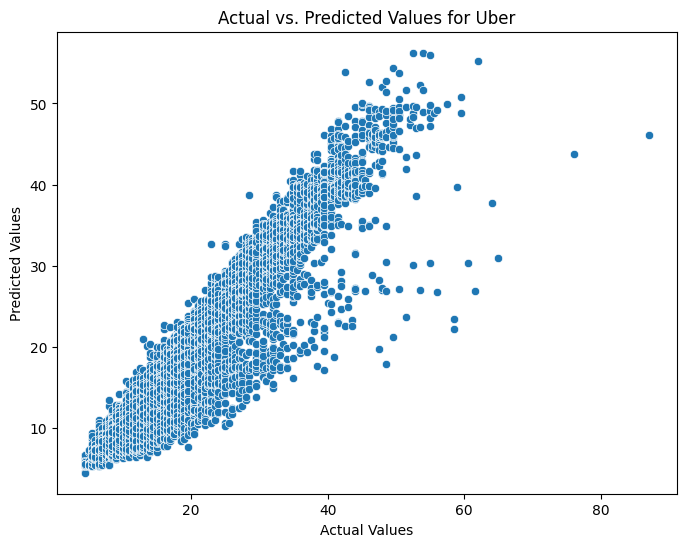

In [ ]:
# Plot a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=result_df_uber, palette='viridis')
plt.title('Actual vs. Predicted Values for Uber')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

result_df_uber['diff'] = abs(result_df_uber['Actual'] - result_df_uber['Predicted']).round()

sorted_diff_uber = result_df_uber['diff'].sort_values(ascending=True)

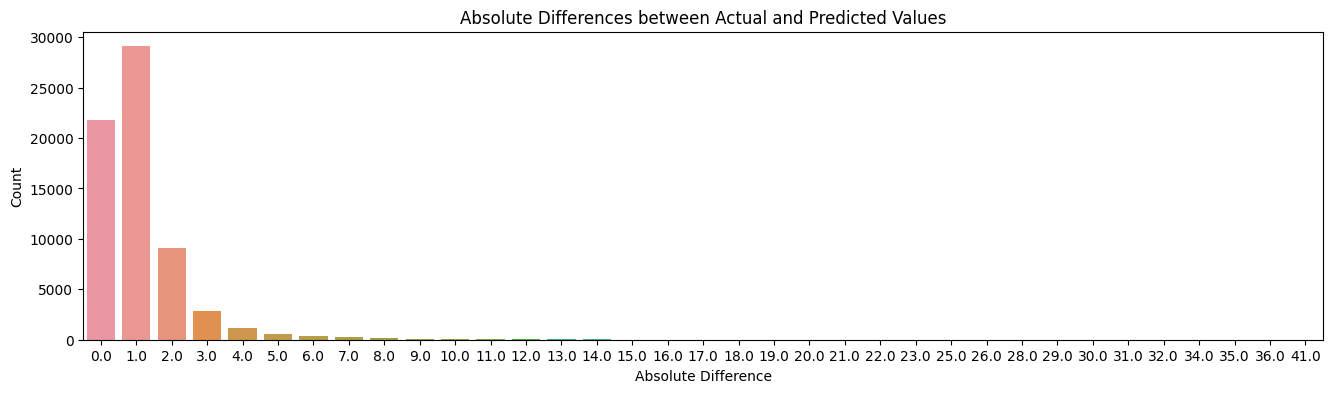

In [ ]:
# Create a count plot using seaborn
plt.figure(figsize=(16, 4))
sns.countplot(x = sorted_diff_uber)
plt.title('Absolute Differences between Actual and Predicted Values')
plt.xlabel('Absolute Difference')
plt.ylabel('Count')
plt.show()

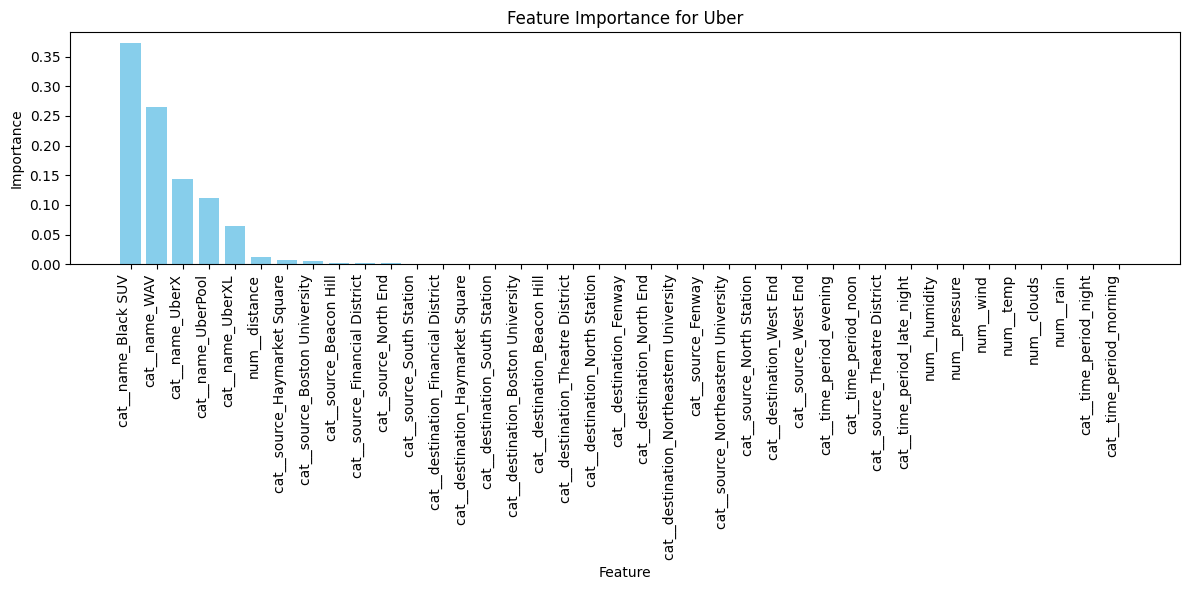

In [ ]:
# plotting importance feature for Uber
feature_importances_uber = xgb_uber_bayes_search.best_estimator_.named_steps['xgbregressor'].feature_importances_

feature_names_uber = xgb_uber_bayes_search.best_estimator_[:-1].get_feature_names_out()

importance_df_uber = pd.DataFrame({'Feature': feature_names_uber, 'Importance': feature_importances_uber})

importance_df_uber = importance_df_uber.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importance_df_uber['Feature'], importance_df_uber['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Uber')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()



---



In [ ]:
# Lyft actual vs. predicted values
y_pred_tree_lyft = xgb_lyft_bayes_search.predict(X_test_lyft)
result_df_lyft = pd.DataFrame({'Actual': y_test_lyft, 'Predicted': y_pred_tree_lyft})
result_df_lyft = result_df_lyft.sort_values(by='Actual')

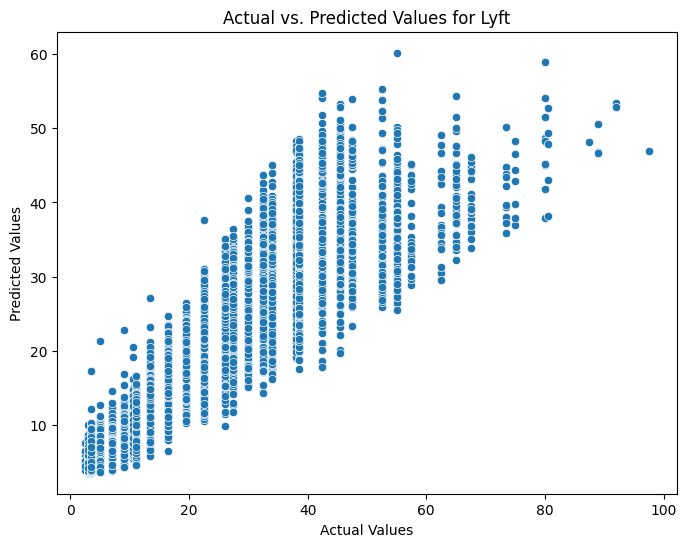

In [ ]:
# plotting compare actual against predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=result_df_lyft, palette='viridis')
plt.title('Actual vs. Predicted Values for Lyft')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
result_df_lyft['diff'] = abs(result_df_lyft['Actual'] - result_df_lyft['Predicted']).round()

sorted_diff_lyft = result_df_lyft['diff'].sort_values(ascending=True)

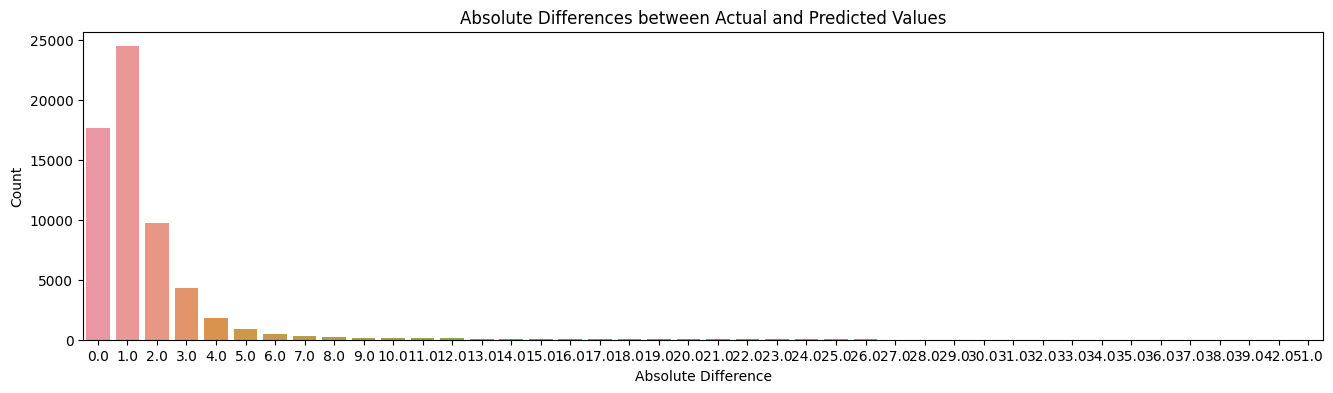

In [ ]:
# Create a count plot using seaborn
plt.figure(figsize=(16, 4))
sns.countplot(x=sorted_diff_lyft)
plt.title('Absolute Differences between Actual and Predicted Values')
plt.xlabel('Absolute Difference')
plt.ylabel('Count')
plt.show()

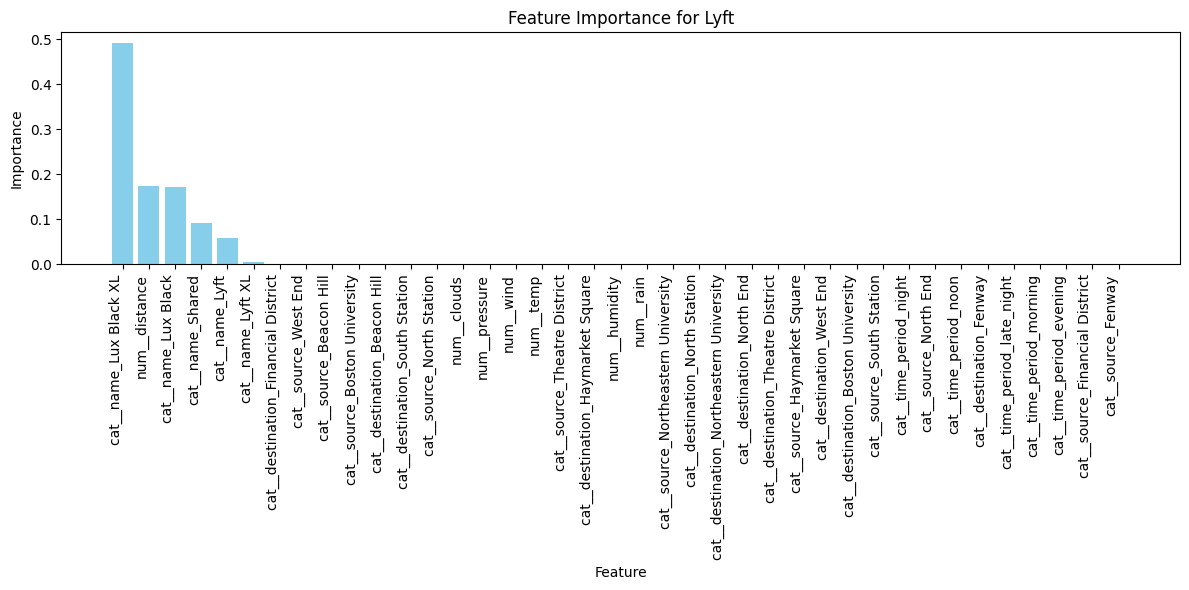

In [ ]:
# plotting importance feature for Lyft
feature_importances_lyft = tree_lyft_bayesian_search.best_estimator_.named_steps['decisiontreeregressor'].feature_importances_

feature_names_lyft = tree_lyft_bayesian_search.best_estimator_[:-1].get_feature_names_out()

importance_df_lyft = pd.DataFrame({'Feature': feature_names_lyft, 'Importance': feature_importances_lyft})

importance_df_lyft = importance_df_lyft.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importance_df_lyft['Feature'], importance_df_lyft['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Lyft')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# Price prediction

In [ ]:
# Price prediction for Uber
test_data_uber = pd.DataFrame({
    'distance': [4.05],
    'destination': 'Financial District',
    'source': 'Boston University',
    'cab_type' : ['Uber'],
    'name': ['UberXL'],
    'temp': [39],
    'clouds': [0.7],
    'pressure': [1008],
    'rain': [0.05],
    'humidity': [0.76],
    'wind': [6.8],
    'time_period': ['afternoon']
})
test_data_uber

,distance,destination,source,cab_type,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,4.05,Financial District,Boston University,Uber,UberXL,39,0.7,1008,0.05,0.76,6.8,afternoon


In [ ]:
# Price prediction  for Lyft
test_data_lyft = pd.DataFrame({
    'distance': [4.05],
    'destination': 'Financial District',
    'source': 'Boston University',
    'cab_type' : ['Lyft'],
    'name': ['Lyft XL'],
    'temp': [39],
    'clouds': [0.7],
    'pressure': [1008],
    'rain': [0.05],
    'humidity': [0.76],
    'wind': [6.8],
    'time_period': ['afternoon']
})
test_data_lyft

,distance,destination,source,cab_type,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,4.05,Financial District,Boston University,Lyft,Lyft XL,39,0.7,1008,0.05,0.76,6.8,afternoon


In [ ]:
data_predictions_uber = xgb_uber_bayes_search.best_estimator_.predict(test_data_uber)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = xgb_lyft_bayes_search.best_estimator_.predict(test_data_lyft)
print("The prediction price of Lyft is", data_predictions_lyft)

The prediction price of Uber is [23.334993]
The prediction price of Lyft is [22.248138]


In [ ]:
# Change the destination
test_data_uber_1 = test_data_uber.copy()
test_data_lyft_1 = test_data_lyft.copy()
test_data_uber_1['destination'] = 'Theatre District'
test_data_lyft_1['destination'] = 'Theatre District'
test_data_uber_1['distance'] = 2.9
test_data_lyft_1['distance'] = 2.9
data_predictions_uber = xgb_uber_bayes_search.best_estimator_.predict(test_data_uber_1)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = xgb_lyft_bayes_search.best_estimator_.predict(test_data_lyft_1)
print("The prediction price of Lyft is", data_predictions_lyft)

The prediction price of Uber is [18.100248]
The prediction price of Lyft is [20.249187]


In [ ]:
# Change the time_period
test_data_uber_2 = test_data_uber.copy()
test_data_lyft_2 = test_data_lyft.copy()
test_data_uber_2['time_period'] = 'evening'
test_data_lyft_2['time_period'] = 'evening'
data_predictions_uber = xgb_uber_bayes_search.best_estimator_.predict(test_data_uber_2)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = xgb_lyft_bayes_search.best_estimator_.predict(test_data_lyft_2)
print("The prediction price of Lyft is", data_predictions_lyft)

The prediction price of Uber is [23.310923]
The prediction price of Lyft is [22.345005]


In [ ]:
# Change the Vehicle type
test_data_uber_2 = test_data_uber.copy()
test_data_lyft_2 = test_data_lyft.copy()
test_data_uber_2['name'] = 'Black SUV'
test_data_lyft_2['name'] = 'Lux Black XL'
data_predictions_uber = xgb_uber_bayes_search.best_estimator_.predict(test_data_uber_2)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = xgb_lyft_bayes_search.best_estimator_.predict(test_data_lyft_2)
print("The prediction price of Lyft is", data_predictions_lyft)

test_data_uber_1

The prediction price of Uber is [40.76876]
The prediction price of Lyft is [43.09772]


,distance,destination,source,cab_type,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,2.9,Theatre District,Boston University,Uber,UberXL,39,0.7,1008,0.05,0.76,6.8,afternoon


# Predictions on test data

In [ ]:
# Uber predictions with best estimator
data_predictions_uber = xgb_uber_bayes_search.best_estimator_.predict(X_test_uber)
data_predictions_uber = pd.DataFrame(data_predictions_uber)
X_test_uber = X_test_uber.reset_index()
X_test_uber['predicted_price'] = data_predictions_uber
X_test_uber.head(10)

,index,distance,cab_type,destination,source,name,temp,clouds,pressure,rain,humidity,wind,time_period,predicted_price
0,460051,3.01,Uber,Boston University,North Station,WAV,32.280000,0.690000,1033.670000,0.000,0.560000,2.360000,evening,11.093656
1,235852,0.56,Uber,Haymarket Square,North Station,UberX,50.740000,1.000000,1003.250000,0.000,0.930000,3.930000,evening,7.184306
2,521026,2.72,Uber,West End,Fenway,UberX,40.430000,0.890000,1014.006000,0.000,0.932000,2.634000,late_night,10.275254
3,369283,1.35,Uber,North End,Beacon Hill,UberXL,41.310000,0.893333,991.560000,0.002,0.633333,9.490000,afternoon,13.635898
4,406967,1.08,Uber,Northeastern University,Back Bay,Black,41.153333,0.633333,991.586667,0.000,0.623333,10.113333,afternoon,15.626392
5,657376,2.65,Uber,Theatre District,Fenway,WAV,48.600000,0.560000,1021.350000,0.000,0.720000,5.370000,evening,10.958372
6,481690,1.35,Uber,Haymarket Square,Beacon Hill,Black SUV,23.980000,0.500000,1008.790000,0.000,0.510000,14.930000,noon,26.742880
7,399507,2.45,Uber,North Station,Northeastern University,WAV,19.940000,0.450000,1031.710000,0.000,0.630000,2.740000,noon,11.089293
8,528035,2.34,Uber,Back Bay,North End,UberPool,42.960000,0.965000,988.545000,0.000,0.895000,9.720000,afternoon,10.013367
9,51934,1.92,Uber,Northeastern University,Beacon Hill,Black SUV,51.840000,0.710000,1021.600000,0.000,0.750000,6.740000,afternoon,26.821289


In [ ]:
# Lyft predictions with best estimator
data_predictions_lyft = xgb_lyft_bayes_search.best_estimator_.predict(X_test_lyft)
data_predictions_lyft = pd.DataFrame(data_predictions_lyft)
X_test_lyft = X_test_lyft.reset_index()
X_test_lyft['predicted_price'] = data_predictions_lyft
X_test_lyft.head(10)

,index,distance,cab_type,destination,source,name,temp,clouds,pressure,rain,humidity,wind,time_period,predicted_price
0,635446,3.19,Lyft,Boston University,North Station,Shared,46.920,0.910000,1022.170,0.0000,0.880000,3.990000,afternoon,6.929302
1,13360,3.16,Lyft,Fenway,North Station,Lyft,45.060,0.980000,1012.140,0.0000,0.880000,5.160000,evening,10.729082
2,368367,2.97,Lyft,Fenway,West End,Lux Black XL,39.210,0.440000,1022.810,0.0000,0.740000,7.190000,morning,33.897461
3,324716,0.74,Lyft,Haymarket Square,West End,Shared,37.940,1.000000,1020.070,0.0183,0.860000,1.920000,morning,4.331971
4,574640,3.15,Lyft,Boston University,North Station,Shared,29.880,0.690000,1034.970,0.0000,0.680000,1.950000,night,6.764403
5,496732,2.86,Lyft,Boston University,West End,Lux Black XL,42.860,0.675000,991.295,0.0000,0.715000,8.565000,evening,34.063202
6,553575,0.53,Lyft,North Station,Haymarket Square,Lux Black XL,42.595,0.790000,990.810,0.0000,0.725000,9.325000,evening,27.014526
7,215361,2.39,Lyft,North Station,South Station,Lux Black XL,33.575,0.138333,991.210,0.0000,0.821667,5.773333,noon,32.993515
8,558301,3.17,Lyft,Boston University,Theatre District,Lyft XL,29.820,0.710000,1035.070,0.0000,0.720000,1.610000,late_night,18.120478
9,122649,3.10,Lyft,Fenway,Theatre District,Lyft,34.100,1.000000,1003.700,0.0100,0.940000,9.320000,noon,12.647260


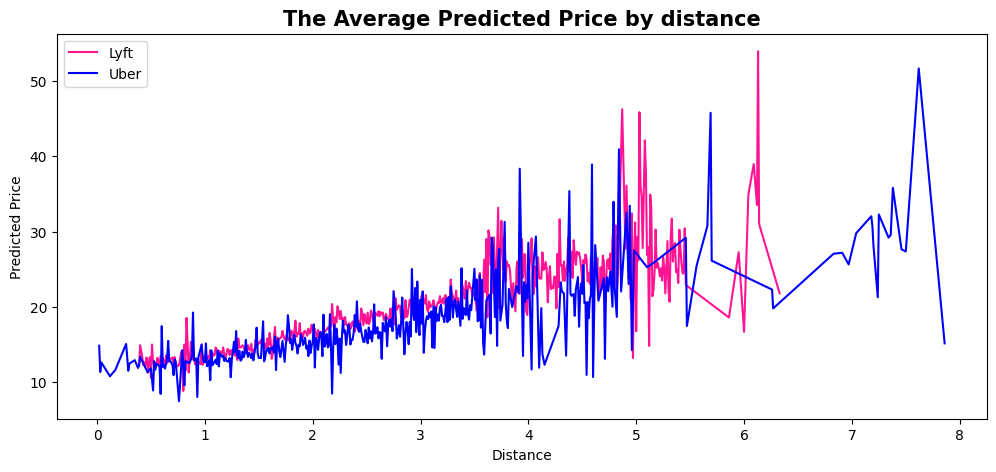

In [ ]:
# plotting distance against predicted price
fig , ax = plt.subplots(figsize = (12,5))
ax.plot(X_test_lyft.groupby('distance').predicted_price.mean().index, X_test_lyft.groupby('distance').predicted_price.mean(), label = 'Lyft', color='deeppink')
ax.plot(X_test_uber.groupby('distance').predicted_price.mean().index, X_test_uber.groupby('distance').predicted_price.mean(), label = 'Uber', color='blue')
ax.set_title('The Average Predicted Price by distance', fontsize= 15, fontweight='bold')
ax.set(xlabel = 'Distance', ylabel = 'Predicted Price' )
ax.legend()
plt.show()

Upon comparing the actual price with the average predicted price, we observed that the latter is consistently higher. Furthermore, beyond a distance of five miles, the average predicted price shows greater fluctuation, potentially attributed to a reduced number of data points.

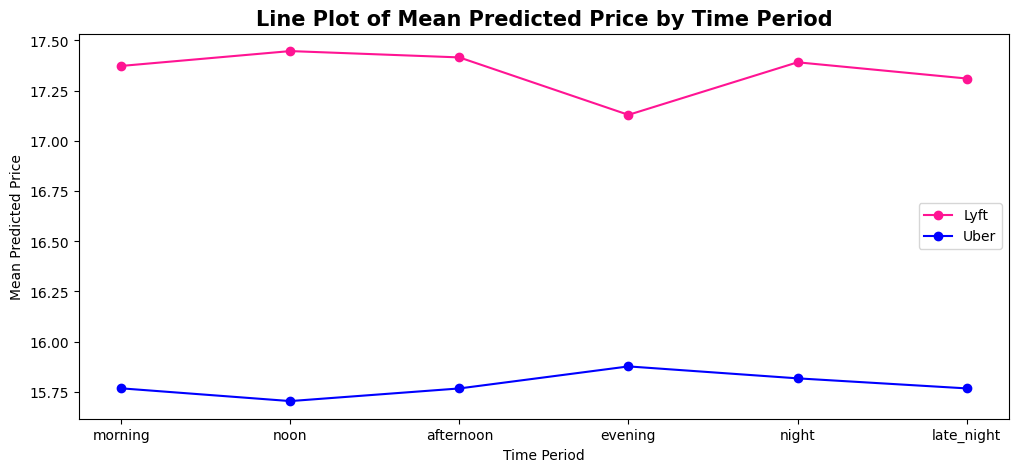

In [ ]:
# plotting time period against predicted price
time_period_order = ['morning', 'noon', 'afternoon', 'evening', 'night', 'late_night']
fig, ax = plt.subplots(figsize=(12, 5))

# reorder the dataframe based on time_period_order
lyft_df_ordered = X_test_lyft.groupby('time_period').predicted_price.mean().loc[time_period_order]
uber_df_ordered = X_test_uber.groupby('time_period').predicted_price.mean().loc[time_period_order]

ax.plot(lyft_df_ordered.index, lyft_df_ordered, label='Lyft', color='deeppink', linestyle='-', marker='o')
ax.plot(uber_df_ordered.index, uber_df_ordered, label='Uber', color='blue', linestyle='-', marker='o')

ax.set_title('Line Plot of Mean Predicted Price by Time Period', fontsize=15, fontweight='bold')
ax.set(xlabel='Time Period', ylabel='Mean Predicted Price')
ax.legend()

plt.show()

Overall, the average predicted price for Lyft is constantly higher than Uber.

Unexpectedly, we observed a price decrease during the evening period for Lyft, in contrast to a price increase for Uber. We speculate that Lyft reduces prices during this time to enhance competitiveness, particularly during peak demand hours.

# Challenges

> - When joining the trips and weather tables, we found out that the data in the weather table were queried by a 5 minute frequency. The weather table could not direcly be joined on the trips table timestamp, since the date-time might not be exactly the same. To overcome this challenge, we added a new column to take the average weather data by hour, and matched it to the trips table on the hour extracted from the timestamp.
> - We had to pick two best models for the Uber and Lyft dataset separately, and since each model had 4 models with 3 search methods, it was challenging to efficiently extract the models with the best performing hyperparameters. To solve this problem, we used for loops to iterate through the different models and the mean test scores. We then used list comprehensions to extract the model with the maximum mean test score and printed out the name of the best-performing models.
> - With a large dataset, we had to limit the number of hyperparameters that we tune in order to run the models efficiently.

# Conclusion

In conclusion, the XGBoost regression model demonstrated the best performance for predicting both Uber and Lyft prices, with the lowest root mean squared error scores compared to other models tested.

By conducting supervised machine learning to predict Uber and Lyft surge prices, we learned the importance of finding the most accurate and cost-effective machine learning model to solve business problems with limited resources. With time and compute power limitations, we needed to use a select number of hyperparameters to tune our models and find the best prediction model for Uber and Lyft separately.

Feature importance analysis found that the distance traveled was the most influential factor affecting price predictions for both Uber and Lyft. This aligns with intuition as trip distance directly impacts the fare amount. Other top predictors were location attributes like pick-up location, destination, and time period.

Comparisons of actual versus predicted price values showed the XGBoost models were relatively accurate, with most predictions closely aligned or slightly under-estimating the actual fares. The predicted prices fell within a $5 difference for a majority of the test cases.

Overall, our analysis and modeling provides an effective framework to predict Uber and Lyft pricing based on a variety of features like trip details, geographic locations, vehicle types and external factors like weather. The XGBoost approach outperformed other regression models, demonstrating feasibility to deliver accurate price estimates to riders using historical Uber and Lyft data trends. With some refinement, the predictive models show promise to be integrated into passenger travel planning and budgeting use cases going forward.